<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP

# Part 3 : EDA and Modeling 

### Contents:
* [Import Libraries and Datasets](#Import-Libraries-and-Datasets)
* [EDA](#EDA)
* [Modeling](#Modeling)
* [Misclassification Analysis](#Misclassification-Analysis)
* [Conclusion](#Conclusion)

## Organistation of Notebooks:
1. [Introduction](./01_Introduction.ipynb)
2. [Web-scraping and Data Processing](./02_WebScraping_DataProcessing.ipynb)
3. EDA and Modeling

## Import Libraries and Datasets

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud#, STOPWORDS, ImageColorGenerator

# from sklearn.model_selection import train_test_split

# from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier
)

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
posts = pd.read_csv('../data/posts.csv')

In [4]:
X = posts['processed_text_lem']
y = posts['subreddit_cat']
# Split the data into the training and testing sets.
# stratify=y means to split the proportion of y into both x and y
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

## EDA

### Functions are defined here to plot barchart for EDA

In [5]:
def vectorize(vectorizer, df):

    # Fit the vectorizer on our train corpus.
    # Transform the train corpus.
    df = vectorizer.fit_transform(df)
    
    # get feature names
    features = vectorizer.get_feature_names()
    
    # transform the test corpus
#     df_test = vectorizer.transform(df_test)
    
    return df, features

In [6]:
def barplot_words(vectorizer, X_df, y_df):
    
    df_vect, features = vectorize(vectorizer,X_df)
    df = pd.DataFrame(df_vect.todense(),  
                          columns=features)
    y_df = y_df.reset_index(drop=True)
    df = df.merge(y_df, how='left', left_index=True, right_index=True)
    
    rows = round(len(df['subreddit_cat'].unique())/2)
    fig, ax = plt.subplots(rows, 2, figsize=(18, 16))
    ax = ax.ravel()
    

    for idx, subreddit in enumerate(df['subreddit_cat'].unique()):
        df_desc = df.loc[df['subreddit_cat'] == subreddit, [col for col in df.columns if col != 'subreddit_cat']].sum().sort_values(ascending=False)
#         column_index = np.sort(df_desc.index)[::-1]
#         feature_list = [df.columns[i] for i in column_index]
#         cvec_wc = WordCloud(background_color="white", max_words=150, colormap='cividis').generate_from_frequencies(df_desc.T)

        
        bp = sns.barplot(
                    # y to specify list of category
                    y=df_desc.index[:15], 
                    # x to specify the data to the list of category
                    x=df_desc[:15],


                    ax=ax[idx]        
        )
        bp.set_xlabel('Frequency', fontdict={'fontsize':12, 'fontweight': 'bold'})
        bp.set_ylabel('Words', fontdict={'fontsize':12, 'fontweight': 'bold'})
        if subreddit == 0:
            bp.set_title(f'Word Count in Mobile Gaming Subreddit', fontdict={'fontsize':16, 'fontweight': 'bold'})
        else:
            bp.set_title(f'Word Count in Board Games Subreddit', fontdict={'fontsize':16, 'fontweight': 'bold'})
#         ax[idx].imshow(cvec_wc)
#         ax[idx].axis('off')
    if type(vectorizer) == type(CountVectorizer()):
        vectorizer_name = 'Count Vectorizer'
    elif type(vectorizer) == type(TfidfVectorizer()):
        vectorizer_name = 'Tf-idf Vectorizer'
        
    fig.suptitle(vectorizer_name, fontsize=20, fontweight='bold', y=0.92)   
    
    if (len(df['subreddit_cat'].unique()) % 2) != 0:
    # remove extra subplot that are not used
        ax.flat[-1].set_visible(False)
#     plt.tight_layout()
    plt.show()

In [7]:
# Instantiate a CountVectorizer.
# help to turn all into lowercase
# takes in entire corpus
# builds the vocab, which is the column names (unique tokens)
# counts to fill the rows
cvec = CountVectorizer(stop_words='english')
tvec = TfidfVectorizer(stop_words='english')

# X_train_cvec, X_test_cvec, features_name_cvec = vectorize(cvec, X_train, dX_test)
# X_train_tvec, X_test_tvec, features_name_tvec = vectorize(tvec, X_train, dX_test)

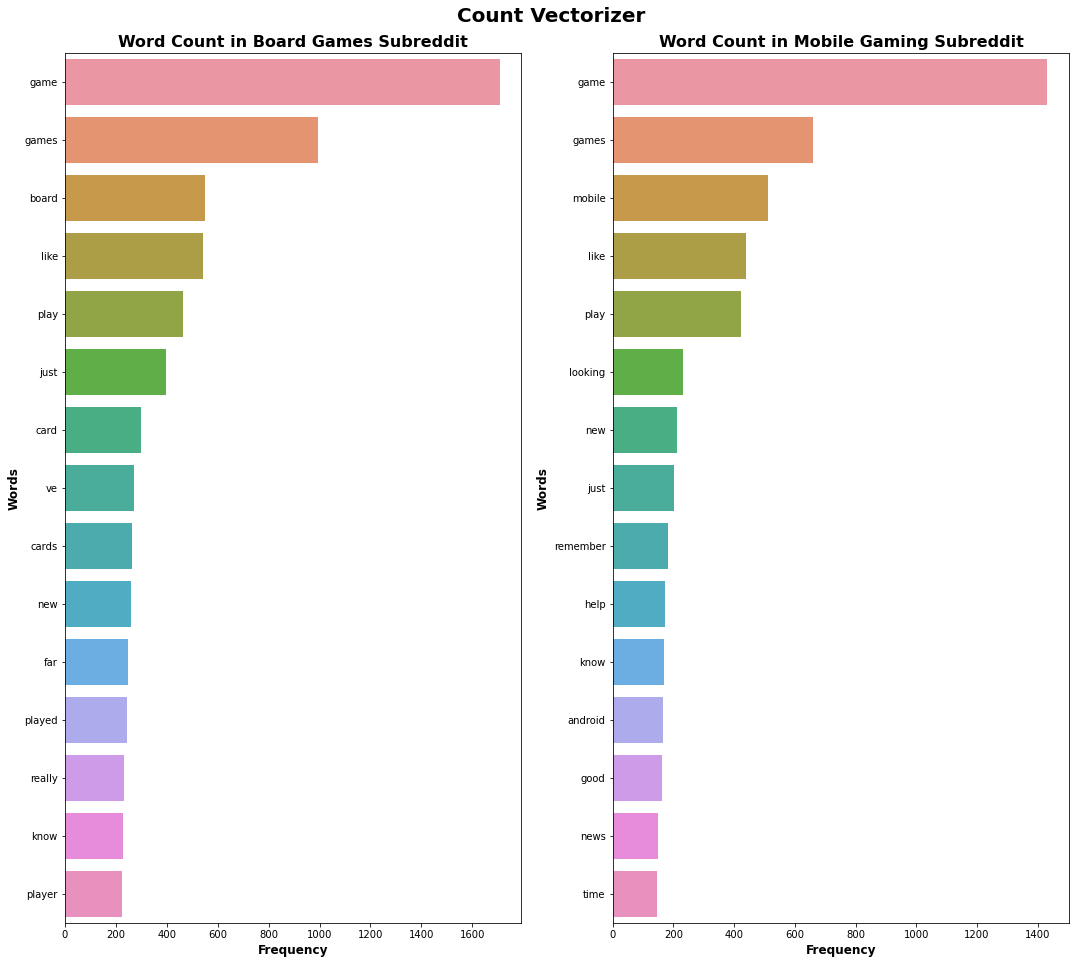

In [8]:
barplot_words(cvec, X_train, y_train)

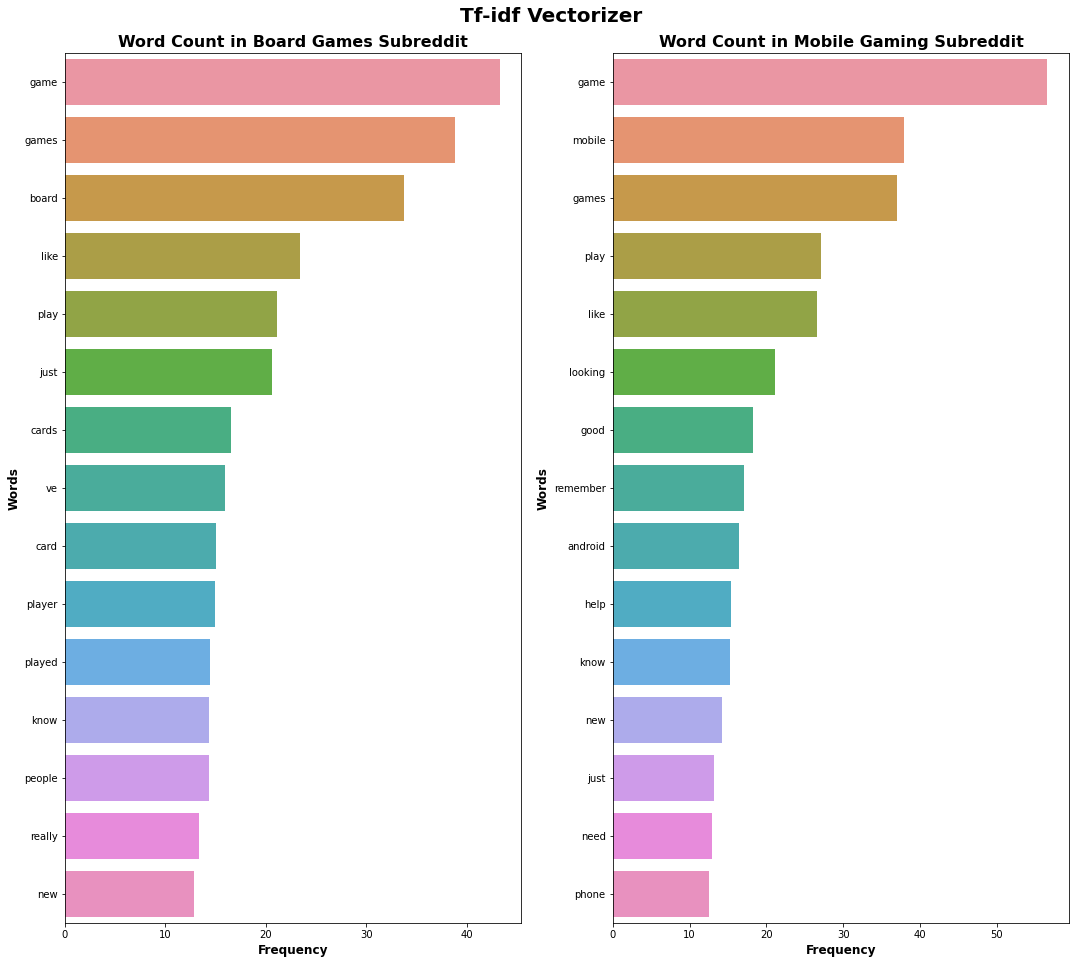

In [9]:
barplot_words(tvec, X_train, y_train)

### Observations:

It can be observed from the 2 barcharts that what are the most frequency occurence words that appeared in the 2 different subreddit catogories. By looking at the top 10 occurence of the word for the 'boardgames' and 'MobileGaming' subreddit groups, it can help us to include some of the words to the stopwords when we do our modelling. Words like 'mobile', 'android', phone', 'card', 'board' are words that we can distinctly differentiate from the 2 subbreddit groups. Hence, in order to build a more robust model, these words are added to the stopwords for modeling. Other words like 'games', 'play', 'new' , 'like', 'just' are some words that appear in both subbreddit, which might not be helpful in correctly classifying the 2 categories, are also added to the stopwords for modeling.

In [10]:
my_stopwords = ['games', 'game', 'mobile', 'board', 'android', \
                'like', 'phone', 'card', 'cards'] 
eng_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())
all_stopwords = my_stopwords + eng_stopwords

## Modeling

### Functions are defined here to plot the coefficient, feature importance and the feature log. probability for the as well as computing the confusion matrix for the different models

In [11]:
def plot_top_features(gv_model_list, vectorizer_list, class_model, is_boardgame, num_features):
    rows = round(len(gv_model_list) / 2)
    fig, ax = plt.subplots(rows, 2, figsize=(18, 10))
    ax = ax.ravel()
    
    for idx, gv_model in enumerate(gv_model_list):

        feature_list = gv_model.best_estimator_[vectorizer_list[idx]].get_feature_names()
        
        if class_model == 'nb':
            
            plot_title = 'Naive Bayes'
            
            if is_boardgame:
                #  get the probability diff 
                # higher means tend towards boardgame
                log_prob_diff = gv_model.best_estimator_[class_model].feature_log_prob_[1] \
                                      - gv_model.best_estimator_[class_model].feature_log_prob_[0]

            
            else:
                #  get the probability diff 
                # higher means tend towards mobilegame
                log_prob_diff = gv_model.best_estimator_[class_model].feature_log_prob_[0] \
                                      - gv_model.best_estimator_[class_model].feature_log_prob_[1]
                
            # sort the index of coef in descending order
            log_prob_diff_idx = log_prob_diff.argsort()[::-1]
            # map index to feature list
            feature = [feature_list[i] for i in log_prob_diff_idx]
            # sort coef in desc order
            feature_impt = np.sort(log_prob_diff)[::-1]
                
        
        elif class_model == 'logreg':
            
            plot_title = 'Logistic Regression'

            if is_boardgame:
#             if class_model == 'logreg':
                # sort the index of coef in descending order
                coef_idx = gv_model.best_estimator_[class_model].coef_[0].argsort()[::-1]
                # map index to feature list
                feature = [feature_list[i] for i in coef_idx]
                # sort coef in desc order
                feature_impt = np.sort(
                                gv_model.best_estimator_[class_model].coef_[0]
                )[::-1]

            else:
#             if class_model == 'logreg':
            # sort the index of coeff. in ascending order
                coef_idx = gv_model.best_estimator_[class_model].coef_[0].argsort()
                # map index to feature list and coefficient
                feature = [feature_list[i] for i in coef_idx]
                # sort the index of coef in asc order
                feature_impt = np.sort(
                                gv_model.best_estimator_[class_model].coef_[0]
                )[::1]

            
        if vectorizer_list[idx] == 'cvec':
            bp = sns.barplot(
                     # y to specify list of category
                    y=feature[:num_features], 
                     # x to specify the data to the list of category
                    x=feature_impt[:num_features],
                    ax=ax[idx]        
            )
    #             bp.axvline(80, color='red')
            bp.set_title(
                'Top 10 Features for Count Vectorizer',
                fontdict={'fontsize':14, 'fontweight': 'bold'}
            )
#             bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
            bp.set_ylabel('Words', fontdict={'fontsize':12, 'fontweight': 'bold'})
    
            if class_model == 'logreg':
                bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
            elif class_model == 'nb':
                bp.set_xlabel('Relative Log. Probability', fontdict={'fontsize':12, 'fontweight': 'bold'})
                
        elif vectorizer_list[idx] == 'tvec':
            bp = sns.barplot(
                     # y to specify list of category
                    y=feature[:num_features], 
                      # x to specify the data to the list of category
                    x=feature_impt[:num_features], 
                    ax=ax[idx]        
            )
    #             bp.axhline(80, color='red')
            bp.set_title(
                'Top 10 Features for Tf-idf Vectorizer',
                fontdict={'fontsize':14, 'fontweight': 'bold'}
            )
#             bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
            bp.set_ylabel('Words', fontdict={'fontsize':12, 'fontweight': 'bold'})
    
            if class_model == 'logreg':
                bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
            elif class_model == 'nb':
                bp.set_xlabel('Relative Log. Probability', fontdict={'fontsize':12, 'fontweight': 'bold'})

    fig.suptitle(plot_title, fontsize=18, fontweight='bold', y=0.95)
    
    if (len(gv_model_list) % 2) != 0:
        # remove extra subplot that are not used
        ax.flat[-1].set_visible(False)
#     plt.tight_layout()
    plt.show()

In [12]:
def plot_top_features_tree(gv_model_list, vectorizer_list, class_model, num_features):
    rows = round(len(gv_model_list) / 2)
    fig, ax = plt.subplots(rows, 2, figsize=(18, 10))
    ax = ax.ravel()
    
    for idx, gv_model in enumerate(gv_model_list):
        
        feature_list = gv_model.best_estimator_[vectorizer_list[idx]].get_feature_names()
        
        if class_model == 'dt' or class_model == 'rf' or class_model == 'et':
            
            if class_model == 'dt':
                plot_title = 'Decision Tree'
            elif class_model == 'rf':
                plot_title = 'Random Forest'
            elif class_model == 'et':
                plot_title = 'Extra Trees'
                
            feature_impt = gv_model.best_estimator_[class_model].feature_importances_

        
        elif class_model == 'bag':
            
            plot_title = 'Bag of Trees'
            
            # axis=0, take all the rows to compute the mean for each column
            # axis=1, take all the columns to compute the mean for each row
            feature_impt = np.mean([
                tree.feature_importances_ for tree in gv_model.best_estimator_[class_model]
            ], axis=0)
            
        df = pd.DataFrame({
                'features_impt':feature_impt, 
                'column_name':feature_list}
        )
        df = df.sort_values(by='features_impt', ascending=False)

        if vectorizer_list[idx] == 'cvec':
            bp = sns.barplot(
                     # y to specify list of category
                    y=df['column_name'][:num_features], 
                     # x to specify the data to the list of category
                    x=df['features_impt'][:num_features],
                    ax=ax[idx]        
            )

            bp.set_title(
                'Top 10 Features for Count Vectorizer',
                fontdict={'fontsize':14, 'fontweight': 'bold'}
            )

            bp.set_ylabel('Words', fontdict={'fontsize':12, 'fontweight': 'bold'})
            bp.set_xlabel('Feature Score', fontdict={'fontsize':12, 'fontweight': 'bold'})
#             if class_model == 'logreg':
#                 bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
#             elif class_model == 'nb':
#                 bp.set_xlabel('Log. Probability', fontdict={'fontsize':12, 'fontweight': 'bold'})
                
        elif vectorizer_list[idx] == 'tvec':
            bp = sns.barplot(
                     # y to specify list of category
                    y=df['column_name'][:num_features], 
                     # x to specify the data to the list of category
                    x=df['features_impt'][:num_features],
                    ax=ax[idx]        
            )

            bp.set_title(
                'Top 10 Features for Tf-idf Vectorizer',
                fontdict={'fontsize':14, 'fontweight': 'bold'}
            )
            bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
            bp.set_ylabel('Words', fontdict={'fontsize':12, 'fontweight': 'bold'})
#             bp.set_xlabel('Feature Score', fontdict={'fontsize':12, 'fontweight': 'bold'})
#             if class_model == 'logreg' :
#                 bp.set_xlabel('Coefficient', fontdict={'fontsize':12, 'fontweight': 'bold'})
#             elif class_model == 'nb':
#                 bp.set_xlabel('Log. Probability', fontdict={'fontsize':12, 'fontweight': 'bold'})


    #         bp.set_title(f'Bar chart for {feature}', fontdict={'fontsize':16, 'fontweight': 'bold'})
    
    fig.suptitle(plot_title, fontsize=18, fontweight='bold', y=0.95)
    
    if (len(gv_model_list) % 2) != 0:
        # remove extra subplot that are not used
        ax.flat[-1].set_visible(False)
#     plt.tight_layout()
    plt.show()

In [13]:
def compute_metrics(gridsearch_model, test_var, test_outcome, df_results):
    
    # df to save the metrics
    df = df_results
    
    preds = gridsearch_model.predict(test_var)
    
    tn, fp, fn, tp = confusion_matrix(test_outcome, preds).ravel()
    
    accuracy = (tp + tn) / (tp + fp + tn +fn)
    misclassification = 1 - accuracy
    # true positive rate/recall
    sensitivity = tp / (tp + fn)
    # true negative rate
    specificity = tn / (tn + fp)
    # positive predictive value, % correct for those that are predicted positive
    precision = tp / (tp + fp)
    # f1 score is the harmonic mean of precision and recall
    # if care about precision and recall roughly the same amount
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    fp_list = [test_var[test_var.index[idx]] for idx, (actual, predict) in enumerate(zip(test_outcome, preds)) if (actual != predict) and predict == 1]
    fn_list = [test_var[test_var.index[idx]] for idx, (actual, predict) in enumerate(zip(test_outcome, preds)) if (actual != predict) and predict == 0]

    plot_confusion_matrix(gridsearch_model, test_var, test_outcome, cmap='Blues', values_format='d');

    column_names = ['model', 'vectorizer', 'accuracy', 'misclassification', 'sensitivity', 'specificity',\
                    'precision', 'f1_score', 'tn', 'tp', 'fn', 'fp', 'fn_list', 'fp_list']
#     print(len(column_names))
    if type(gridsearch_model.estimator[0]) == type(CountVectorizer()):
        data = [gridsearch_model.estimator[1], 'cvec', accuracy, misclassification, sensitivity, specificity, \
                precision, f1_score, tn, tp, fn, fp, fn_list, fp_list]
#         print(len(data))
    elif type(gridsearch_model.estimator[0]) == type(TfidfVectorizer()):
        data = [gridsearch_model.estimator[1], 'tvec', accuracy, misclassification, sensitivity, specificity, \
                precision, f1_score, tn, tp, fn, fp, fn_list, fp_list]
#         print(len(data))
    df = pd.concat([df, save_results(data, column_names)], ignore_index=True)
    
    print(f'Accuracy is {round(accuracy, 4)}.')
    print(f'Misclassification is {round(misclassification, 4)}.')
    print(f'Sensitivity is {round(sensitivity, 4)}.')
    print(f'Specificity is {round(specificity, 4)}.')
    print(f'F1_score is {round(f1_score, 4)}.')
    return df#accuracy, misclassification, sensitivity, specificity, precision, f1_score, fn_list, fp_list
    

In [14]:
def save_results(data, column_names):
    return pd.DataFrame(data=[data], columns=column_names)

### Logistic Regression

In [15]:
# pipeline takes a list of steps
# order-dependent when u declare
# only can have one estimator
pipe_logreg_cvec = Pipeline([
        ('cvec', CountVectorizer(stop_words=all_stopwords)), # transformer
        ('logreg', LogisticRegression()) # estimator
])

In [16]:
# use best params
pipe_logreg_cvec_params = {
    'cvec__max_features': [None], #[None, 2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01], #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [17]:
%%time
pipe_logreg_cvec_gridsearch = GridSearchCV(
            pipe_logreg_cvec, # model to use
            pipe_logreg_cvec_params, # dictionary of hyperparameters to iterate
            cv=5, # no. of folds in CV
            verbose=1 # show the all rows and columns
)

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.8 µs


In [18]:
%%time
# about 2min
# Fit the GridSearchCV object to the data.
pipe_logreg_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 839 ms, sys: 9.47 ms, total: 848 ms
Wall time: 851 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [19]:
# Print out best score.
# from documentation: Mean cross-validated score of the best_estimator
pipe_logreg_cvec_gridsearch.best_score_

0.8713419913419914

In [20]:
# # Print out best params.
# pipe_logreg_cvec_gridsearch.best_params_

In [21]:
# # Print out best estimator.
# pipe_logreg_cvec_gridsearch.best_estimator_

Accuracy is 0.8499.
Misclassification is 0.1501.
Sensitivity is 0.8137.
Specificity is 0.8852.
F1_score is 0.8426.


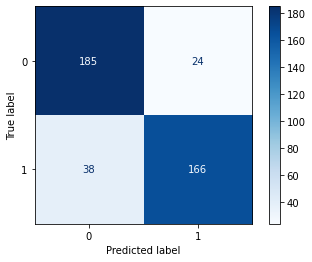

In [22]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_logreg_cvec_gridsearch, X_test, y_test, pd.DataFrame())

In [23]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.84264,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...


In [24]:
# len(df_results['fp_list'][0])

In [25]:
# len(df_results['fn_list'][0])

### Observations: 

The logistic regression model using a count vectorizer achieved an accuracy of 86.68% as well as ssensivity and specificity of 82.35% and 90.9% respectively. These are the 3 metrics that we will be looking out for as the model need to correctly classify the 2 categories which means that the type 1 (false positive) and type 2 (false negative) errors are of equal importance as we need to minimize the false negative and false positive to correctly identify which category each post belongs to.

In [26]:
# pipeline takes a list of steps
# order-dependent when u declare
# only can have one estimator
pipe_logreg_tvec = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=all_stopwords)), # transformer
        ('logreg', LogisticRegression()) # estimator
])

In [27]:
# use best params
pipe_logreg_tvec_params = {
    'tvec__max_features': [None], #[None, 2000, 3000, 4000, 5000],
    'tvec__ngram_range': [(1, 3)], #[(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01] #[0.03, 0.05] # get words that occur > specified value/%
}

In [28]:
%%time
pipe_logreg_tvec_gridsearch = GridSearchCV(
            pipe_logreg_tvec, # model to use
            pipe_logreg_tvec_params, # dictionary of hyperparameters to iterate
            cv=5, # no. of folds in CV
            verbose=1 # show the all rows and columns
)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 20 µs


In [29]:
%%time
# about 2min
# Fit the GridSearchCV object to the data.
pipe_logreg_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 1.12 s, sys: 13.8 ms, total: 1.13 s
Wall time: 1.13 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [30]:
# Print out best score.
pipe_logreg_tvec_gridsearch.best_score_

0.8865174541770287

In [31]:
# # Print out best estimator.
# pipe_logreg_tvec_gridsearch.best_estimator_

In [32]:
# # Print out best params.
# pipe_logreg_tvec_gridsearch.best_params_

Accuracy is 0.8571.
Misclassification is 0.1429.
Sensitivity is 0.8529.
Specificity is 0.8612.
F1_score is 0.855.


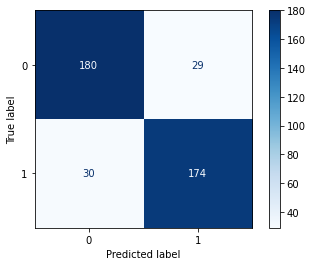

In [33]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_logreg_tvec_gridsearch, X_test, y_test, df_results)

In [34]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


In [35]:
# len(df_results['fp_list'][1])

In [36]:
# len(df_results['fn_list'][1])

### Observations: 

The logistic regression model using a TfidfVectorizer achieved an accuracy of 87.17% as well as ssensivity and specificity of 84.8% and 89.5% respectively. It can be observed that the overall accuracy improved when TfidfVectorizer is used instead of CountVectorizer. This is due to CountVectorizer count the number of occurence of words in the post. This may lead to common words like 'a', 'the', 'an' etc  that do not carry the information of topic that you are interested in. Hence these words will have higher weight than the important words that will help to idenfity the topic that you are interested since the number of occurrences for the common words will be significantly higher than any other term.

With TfidfVectorizer, it uses the inverse document frequency of the words that appear in the post and this would make the common words that do not carry useful information to have lower score than the rarer words that are more useful in determine your topic of interest.

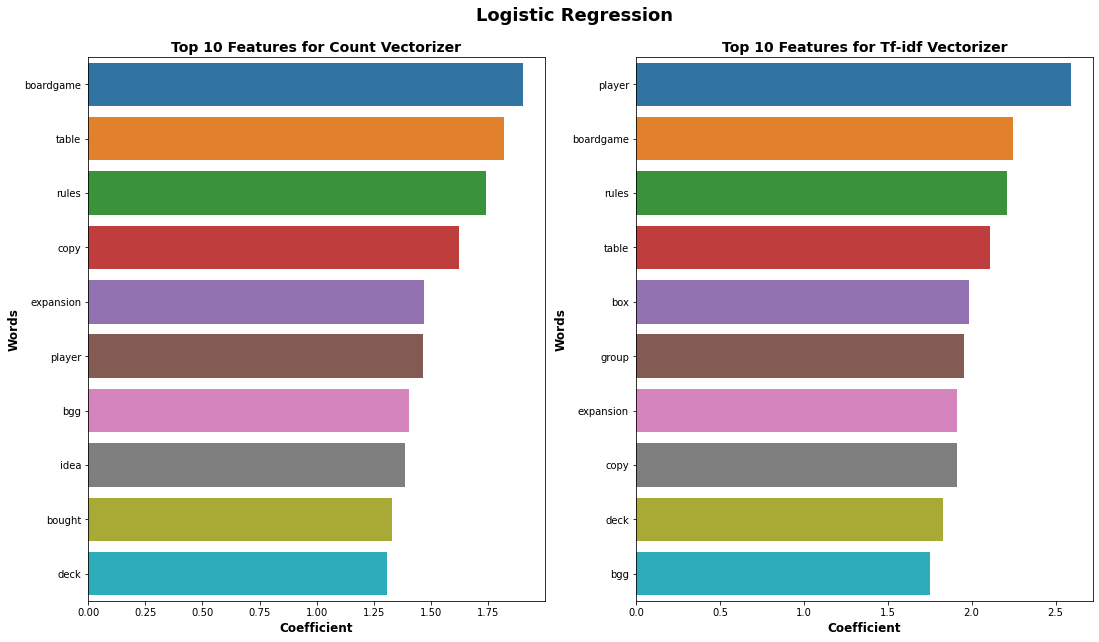

In [37]:
plot_top_features([pipe_logreg_cvec_gridsearch, pipe_logreg_tvec_gridsearch], ['cvec', 'tvec'], 'logreg', True, 10)

### Observations:

The 2 barcharts above show the top 10 words for each vectorizer which will classify the post into the 'boardgames' category. For logistic regression, the cofficient that are positive represent the words that will help to classify into the 'boardgames' category. The word with higher coeffiicient will have more impact in classifying the post into the 'boardgames' category. Hence, from the barcharts, it can be observed that words like 'boardgame', 'cards', 'rules', 'table', 'expansion' are some of the features that will be classified as 'boardgames' category.

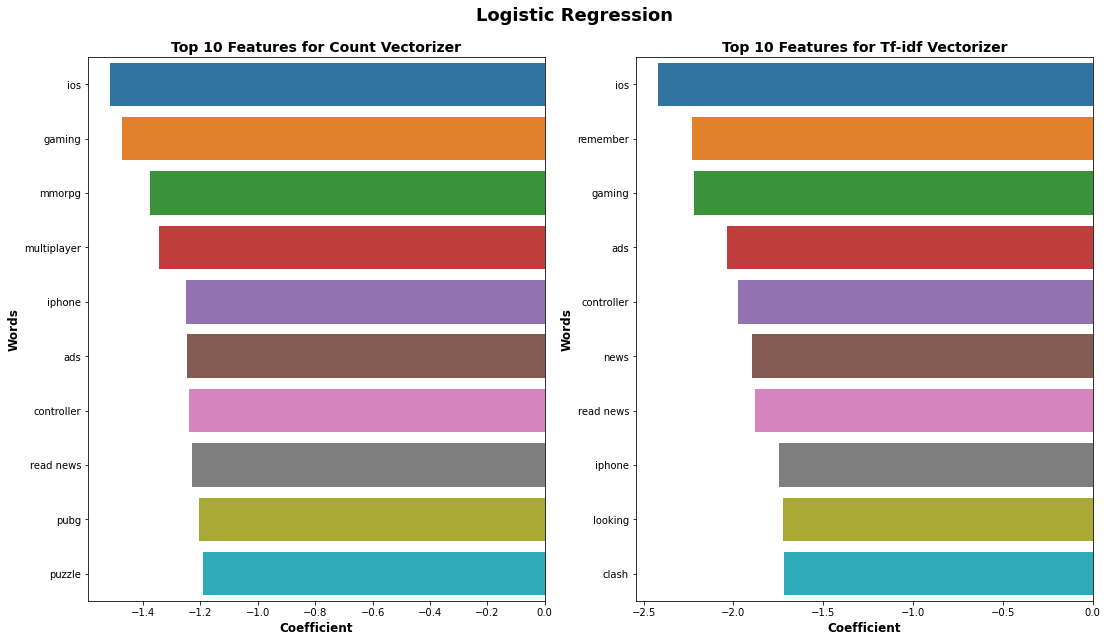

In [38]:
plot_top_features([pipe_logreg_cvec_gridsearch, pipe_logreg_tvec_gridsearch], ['cvec', 'tvec'], 'logreg', False, 10)

### Observations:

Likewise, the 2 barcharts above show the top 10 words for each vectorizer which will classify the post into the 'MobileGaming' category. However, it is the word with negative cofficient that will help to classify into the 'MobileGaming' category. The word with lower coeffiicient will have more impact in classifying the post into the 'MobileGaming' category. Likewise, it can be observed that words like 'multiplayer', 'gaming', 'controller', 'iphone', are some of the features that will be classified as 'MobileGaming' category.

### Naive Bayes

In [39]:
# pipeline takes a list of steps
# order-dependent when u declare
# only can have one estimator
pipe_nb_cvec = Pipeline([
        ('cvec', CountVectorizer(stop_words=all_stopwords)), # transformer
        ('nb', MultinomialNB()) # estimator
])

In [40]:
pipe_nb_cvec_params = {
    'cvec__max_features': [None], #[None, 2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 2)], #[(1, 2)] (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01], #[0.01] 0.03, 0.05], # get words that occur > specified value/%
    'nb__alpha': [0.1] #[0.1, 1, 10, 100]
}

In [41]:
%%time
pipe_nb_cvec_gridsearch = GridSearchCV(
            pipe_nb_cvec, # model to use
            pipe_nb_cvec_params, # dictionary of hyperparameters to iterate
            cv=5, # no. of folds in CV
            verbose=1 # show the all rows and columns
)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 16 µs


In [42]:
%%time
# about 6min
# Fit the GridSearchCV object to the data.
pipe_nb_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 761 ms, sys: 2.12 ms, total: 763 ms
Wall time: 762 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [43]:
# Print out best score.
pipe_nb_cvec_gridsearch.best_score_

0.8883393202542139

In [44]:
# # Print out best params.
# pipe_nb_cvec_gridsearch.best_params_

In [45]:
# # Print out best estiimator.
# pipe_nb_cvec_gridsearch.best_estimator_

Accuracy is 0.8571.
Misclassification is 0.1429.
Sensitivity is 0.8971.
Specificity is 0.8182.
F1_score is 0.8612.


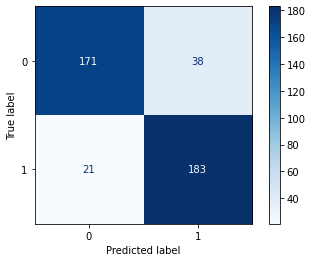

In [46]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_nb_cvec_gridsearch, X_test, y_test, df_results)

In [47]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...


In [48]:
# len(df_results['fn_list'][2])

### Observations: 

The naive bayes model using a count vectorizer achieved an accuracy of 86.2% as well as ssensivity and specificity of 89.7% and 82.78% respectively. 

As Naïve Bayes assumes all the features to be conditionally independent, which means that the algorithm expects the features to be independent. However, this is not always is the case. Hence, some of the features are in fact dependent on each other, the prediction might be poorer than logistic regression as it typically works reasonably well even when some of the features are correlated due to feature space is splited linearly in logistic regression.

In [49]:
# pipeline takes a list of steps
# order-dependent when u declare
# only can have one estimator
pipe_nb_tvec = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=all_stopwords)), # transformer
        ('nb', MultinomialNB()) # estimator
])

In [50]:
pipe_nb_tvec_params = {
    'tvec__max_features': [None], #[None, 2000, 3000, 4000, 5000],
    'tvec__ngram_range': [(1, 2)], #[(1, 2)] (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01], #[0.01] 0.03, 0.05], # get words that occur > specified value/%
    'nb__alpha': [1] #[0.1, 1, 10, 100]
}

In [51]:
%%time
pipe_nb_tvec_gridsearch = GridSearchCV(
            pipe_nb_tvec, # model to use
            pipe_nb_tvec_params, # dictionary of hyperparameters to iterate
            cv=5, # no. of folds in CV
            verbose=1 # show the all rows and columns
)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 22.2 µs


In [52]:
%%time
# about 6min
# Fit the GridSearchCV object to the data.
pipe_nb_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 765 ms, sys: 4.72 ms, total: 770 ms
Wall time: 769 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [53]:
# Print out best score.
pipe_nb_tvec_gridsearch.best_score_

0.8889453808602743

In [54]:
# # Print out best params.
# pipe_nb_tvec_gridsearch.best_params_

In [55]:
# # Print out best estimator.
# pipe_nb_tvec_gridsearch.best_estimator_

Accuracy is 0.8402.
Misclassification is 0.1598.
Sensitivity is 0.8824.
Specificity is 0.799.
F1_score is 0.8451.


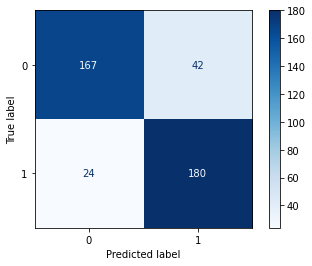

In [56]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_nb_tvec_gridsearch, X_test, y_test, df_results)

In [57]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...


### Observations: 

The naive bayes model using a TfidfVectorizer achieved an accuracy of 84.2% as well as sensivity and specificity of 87.7% and 80.86% respectively. 

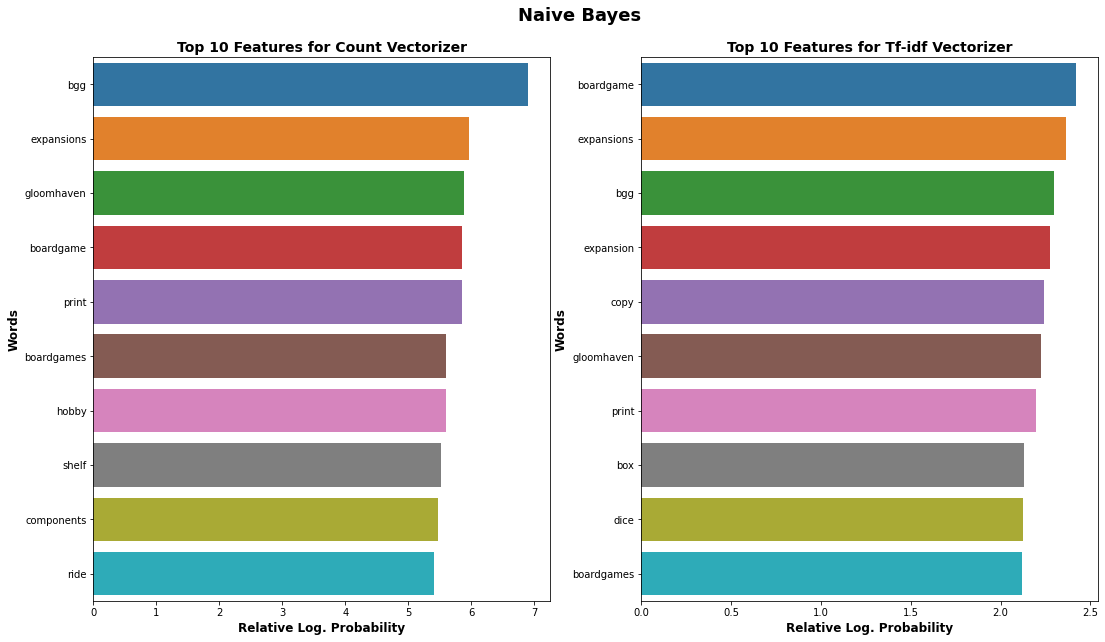

In [58]:
plot_top_features([pipe_nb_cvec_gridsearch, pipe_nb_tvec_gridsearch], ['cvec', 'tvec'], 'nb', True, 10)

### Observations:

The 2 barcharts above show the top 10 words for each vectorizer which will classify the post into the 'boardgames' category. For Naive bayes, the relative log probability of the features that are positive represent the feature that will help to classify into the 'boardgames' category. The word with higher relative log probability value will have more impact in classifying the post into the 'boardgames' category. Hence, from the barcharts, it can be observed that words like 'boardgame', 'expansion', 'bgg' (short form for broadgamegeek) are some of the features that will be classified as 'boardgames' category.

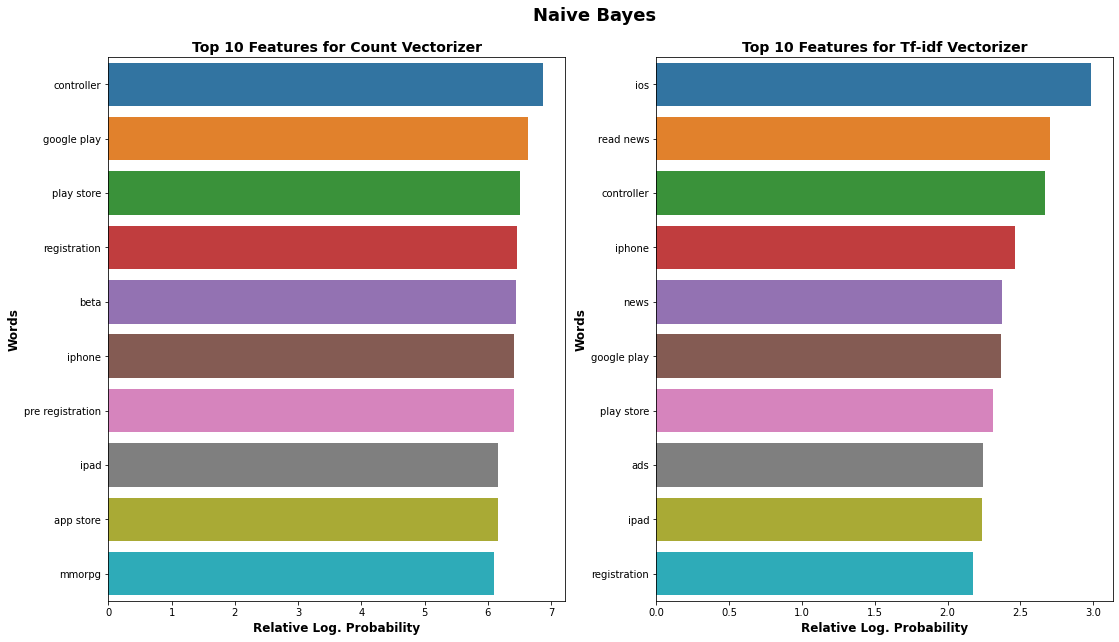

In [59]:
plot_top_features([pipe_nb_cvec_gridsearch, pipe_nb_tvec_gridsearch], ['cvec', 'tvec'], 'nb', False, 10)

### Observations:

The 2 barcharts above show the top 10 words for each vectorizer which will classify the post into the 'boardgames' category. For Naive bayes, the relative log probability of the features that are positive represent the feature that will help to classify into the 'MobileGaming' category. The word with higher relative log probability value will have more impact in classifying the post into the 'boardgames' category. Hence, from the barcharts, it can be observed that words like 'boardgame', 'expansion', 'bgg' (short form for broadgamegeek) are some of the features that will be classified as 'boardgames' category.

### KNN

In [60]:
pipe_knn_cvec = Pipeline([
        ('cvec', CountVectorizer(stop_words=all_stopwords)), # transformer
        ('knn', KNeighborsClassifier()) # estimator
])

In [61]:
# use best params
pipe_knn_cvec_params = {
    'knn__n_neighbors': [5], #range(3, 11, 2),
    'cvec__max_features': [None], #[None, 2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.03] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
    
}

In [62]:
%%time
pipe_knn_cvec_gridsearch = GridSearchCV(
        pipe_knn_cvec, # What is the model we want to fit?
        pipe_knn_cvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 18 µs, sys: 1e+03 ns, total: 19 µs
Wall time: 19.8 µs


In [63]:
%%time
# takes about 6min
pipe_knn_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 867 ms, sys: 6.07 ms, total: 873 ms
Wall time: 873 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [64]:
pipe_knn_cvec_gridsearch.best_score_

0.6571483835313623

In [65]:
# pipe_knn_cvec_gridsearch.best_params_

In [66]:
# pipe_knn_cvec_gridsearch.best_estimator_

Accuracy is 0.6804.
Misclassification is 0.3196.
Sensitivity is 0.4902.
Specificity is 0.866.
F1_score is 0.6024.


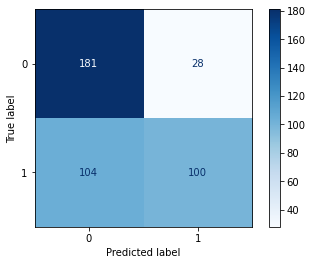

In [67]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_knn_cvec_gridsearch, X_test, y_test, df_results)

In [68]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...


### Observations: 

The k-nearest neighbors model using a count vectorizer achieved an accuracy of 69% as well as ssensivity and specificity of 50% and 87.56% respectively. 

As k-nearest neighbors is a distance-based algorithm, it does not associate which features/words are important to be classified in the 'boardgames' or 'MobileGaming" category, therefore produce very poor results.

In [69]:
pipe_knn_tvec = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=all_stopwords)), # transformer
        ('knn', KNeighborsClassifier()) # estimator
])

In [70]:
pipe_knn_tvec_params = {
    'knn__n_neighbors': [9], #range(3, 11, 2),
    'tvec__max_features': [None, 2000, 3000, 4000, 5000],
    'tvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9 0.95, 0.98], # ignore words occur > specified value/% (def:1.0)
    'tvec__min_df': [0.01], #[0.03, 0.05] # ignore words < specified value/% (def:1)
}

In [71]:
%%time
pipe_knn_tvec_gridsearch = GridSearchCV(
        pipe_knn_tvec, # What is the model we want to fit?
        pipe_knn_tvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 30 µs


In [72]:
pipe_knn_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [73]:
pipe_knn_tvec_gridsearch.best_score_

0.7961149488809063

In [74]:
# pipe_knn_tvec_gridsearch.best_params_

In [75]:
# pipe_knn_tvec_gridsearch.best_estimator_

Accuracy is 0.7651.
Misclassification is 0.2349.
Sensitivity is 0.598.
Specificity is 0.9282.
F1_score is 0.7155.


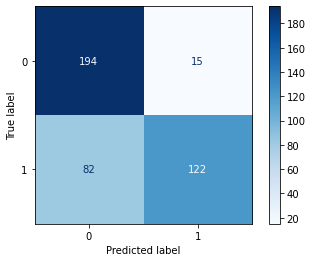

In [76]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_knn_tvec_gridsearch, X_test, y_test, df_results)

In [77]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...


### Observations: 

The k-nearest neighbors model using a TfidfVectorizer achieved an accuracy of 72% as well as ssensivity and specificity of 48% and 96% respectively. 

As k-nearest neighbors is a distance-based algorithm, it does not associate which features/words are important to be classified in the 'boardgames' or 'MobileGaming" category, therefore produce very poor results.

### Decision Tree

In [78]:
# use gini impurity to split
# measure impurity of the node and calculated as (1 - gini)
# Instantiate model with random_state = 42.
# dt = DecisionTreeClassifier(random_state=42)
pipe_dt_cvec = Pipeline([
        ('cvec', CountVectorizer(stop_words=all_stopwords)), # transformer
        ('dt', DecisionTreeClassifier(random_state=42)) # estimator
])

In [79]:
pipe_dt_cvec_params = {
    'dt__min_samples_split': [3], #[2, 3, 4] , # min. no of sample required to split, def:2
    'dt__min_samples_leaf': [1], #[1, 3, 5, 7], # min. no. of samples required a leaf node, def:1
    'cvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [80]:
%%time
pipe_dt_cvec_gridsearch = GridSearchCV(
        pipe_dt_cvec, # What is the model we want to fit?
        pipe_dt_cvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 18.8 µs


In [81]:
%%time
# takes 2min
# takes about 11min
# Fit the GridSearchCV object to the data
pipe_dt_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 908 ms, sys: 2.85 ms, total: 911 ms
Wall time: 910 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [82]:
pipe_dt_cvec_gridsearch.best_score_

0.7615289674864144

In [83]:
# pipe_dt_cvec_gridsearch.best_params_

In [84]:
# pipe_dt_cvec_gridsearch.best_estimator_

Accuracy is 0.7821.
Misclassification is 0.2179.
Sensitivity is 0.7255.
Specificity is 0.8373.
F1_score is 0.7668.


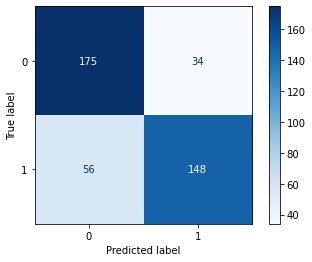

In [85]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_dt_cvec_gridsearch, X_test, y_test, df_results)

In [86]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...


### Observations: 

The decision tree model using a CountVectorizer achieved an accuracy of 80.39% as well as sensivity and specificity of 77.45% and 83.25% respectively. 

In [87]:
# use gini impurity to split
# measure impurity of the node and calculated as (1 - gini)
# Instantiate model with random_state = 42.
# dt = DecisionTreeClassifier(random_state=42)
pipe_dt_tvec = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=all_stopwords)), # transformer
        ('dt', DecisionTreeClassifier(random_state=42)) # estimator
])

In [88]:
pipe_dt_tvec_params = {
    'dt__min_samples_split': [2], #[2, 3, 4] , # min. no of sample required to split, def:2
    'dt__min_samples_leaf': [5], # [1, 3, 5, 7], # min. no. of samples required a leaf node, def:1
    'tvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [89]:
%%time
pipe_dt_tvec_gridsearch = GridSearchCV(
        pipe_dt_tvec, # What is the model we want to fit?
        pipe_dt_tvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21 µs


In [90]:
%%time
# takes 3min
# takes about 11min
# Fit the GridSearchCV object to the data
pipe_dt_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 952 ms, sys: 4.01 ms, total: 956 ms
Wall time: 955 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [91]:
pipe_dt_tvec_gridsearch.best_score_

0.7244726904301372

In [92]:
# pipe_dt_tvec_gridsearch.best_params_

In [93]:
# pipe_dt_tvec_gridsearch.best_estimator_

Accuracy is 0.7312.
Misclassification is 0.2688.
Sensitivity is 0.7451.
Specificity is 0.7177.
F1_score is 0.7325.


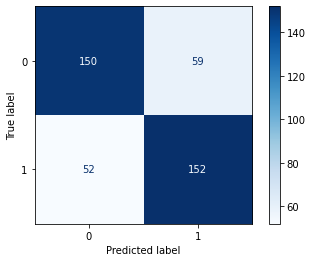

In [94]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_dt_tvec_gridsearch, X_test, y_test, df_results)

In [95]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...


### Observations: 

The decision tree model using a TfidfVectorizer achieved an accuracy of 79.9% as well as sensivity and specificity of 75.98% and 83.73% respectively. 

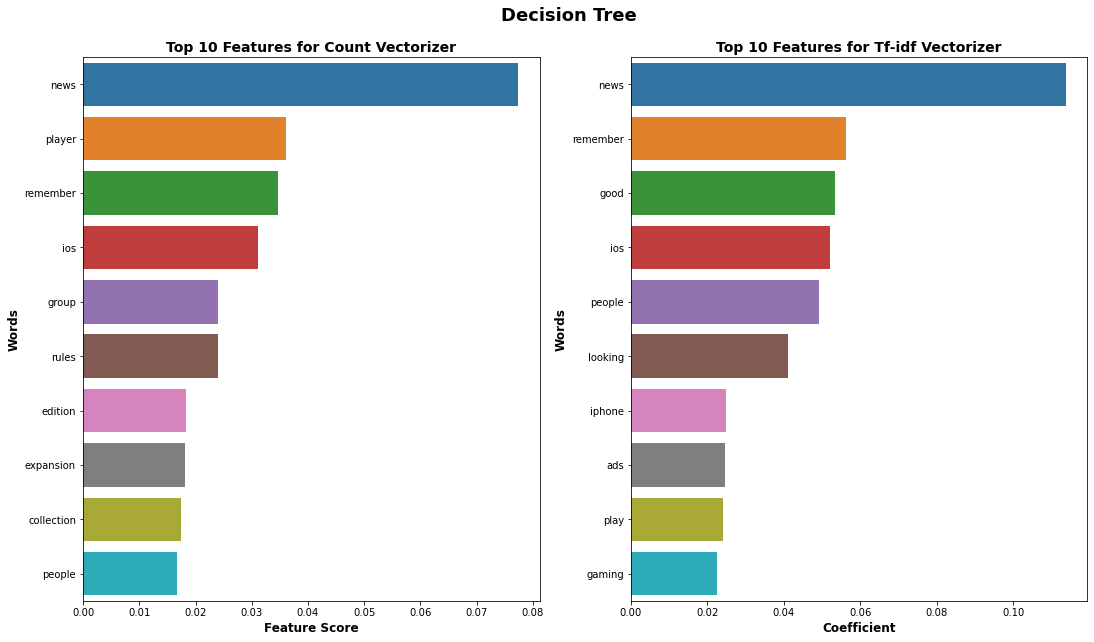

In [96]:
plot_top_features_tree([pipe_dt_cvec_gridsearch, pipe_dt_tvec_gridsearch], ['cvec', 'tvec'], 'dt', 10)

### Observations: 

From the 2 barcharts above, it can be observed that the top 10 features that are important in correctly classifying the 2 subrreddit groups. The higher the score of the features, the more important these features are to correctly classify the 2 groups. However, one limitation is that we do not know which features/words are associated with which subreddit group.

### Boostrap Aggregating (Bagging)

In [97]:
pipe_bag_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stopwords)),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                              random_state=42,
                              n_jobs=-1))
])

In [98]:
pipe_bag_cvec_params = {
    'bag__n_estimators': [500], #[500, 1000, 1500],
    'cvec__ngram_range': [(1, 3)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [99]:
%%time
pipe_bag_cvec_gridsearch = GridSearchCV(
        pipe_bag_cvec, # What is the model we want to fit?
        pipe_bag_cvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.1 µs


In [100]:
%%time
# take about 13min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_bag_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 1.66 s, sys: 256 ms, total: 1.92 s
Wall time: 17.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [101]:
pipe_bag_cvec_gridsearch.best_score_

0.8282914248871697

In [102]:
# pipe_bag_cvec_gridsearch.best_params_

In [103]:
# pipe_bag_cvec_gridsearch.best_estimator_

Accuracy is 0.799.
Misclassification is 0.201.
Sensitivity is 0.7794.
Specificity is 0.8182.
F1_score is 0.793.


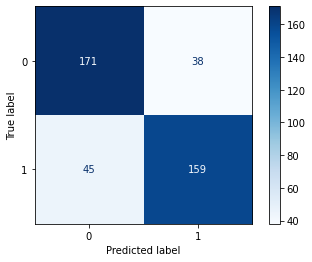

In [104]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_bag_cvec_gridsearch, X_test, y_test, df_results)

In [105]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...


### Observations: 

Bagging is an ensemble model which combines several decision trees to produce better predictive performance than utilizing a single decision tree. The Bagging model using a CountVectorizer achieved an accuracy of 83.29% as well as sensivity and specificity of 79.9% and 86.6% respectively.

In [106]:
pipe_bag_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=all_stopwords)),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                              random_state=42,
                              n_jobs=-1))
])

In [107]:
pipe_bag_tvec_params = {
    'bag__n_estimators': [1000], #[500, 1000, 1500],
    'tvec__ngram_range': [(1, 3)], #[(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [108]:
%%time
pipe_bag_tvec_gridsearch = GridSearchCV(
        pipe_bag_tvec, # What is the model we want to fit?
        pipe_bag_tvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 22.9 µs


In [109]:
%%time
# takes about 20min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_bag_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 2.15 s, sys: 275 ms, total: 2.43 s
Wall time: 43.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [110]:
pipe_bag_tvec_gridsearch.best_score_

0.8191655153357281

In [111]:
# pipe_bag_tvec_gridsearch.best_params_

In [112]:
# pipe_bag_tvec_gridsearcbest_estimator_mator_timator_

Accuracy is 0.8257.
Misclassification is 0.1743.
Sensitivity is 0.7696.
Specificity is 0.8804.
F1_score is 0.8135.


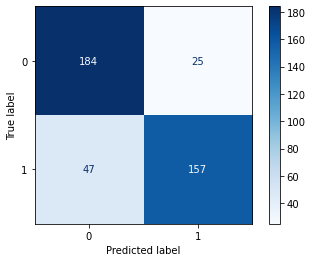

In [113]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_bag_tvec_gridsearch, X_test, y_test, df_results)

In [114]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


### Observations: 

The Bagging model using a TfidfVectorizer achieved an accuracy of 85.71% as well as sensivity and specificity of 79.9% and 91.38% respectively.

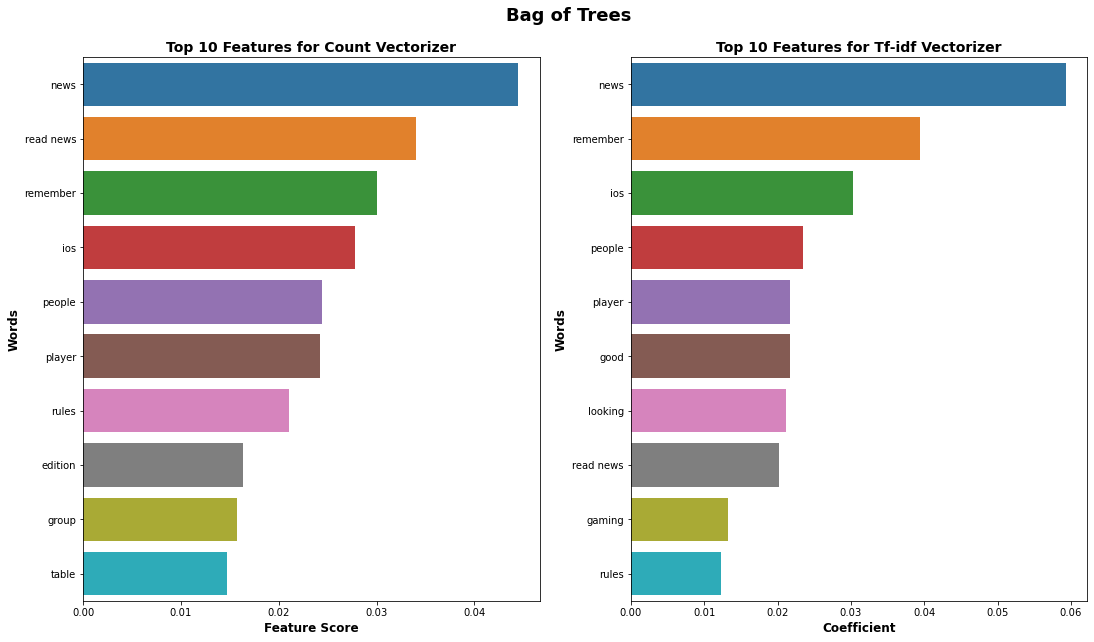

In [115]:
plot_top_features_tree([pipe_bag_cvec_gridsearch, pipe_bag_tvec_gridsearch], ['cvec', 'tvec'], 'bag', 10)

### Observations: 

From the 2 barcharts above, it can be observed that the top 10 features that are important in correctly classifying the 2 subrreddit groups. The higher the score of the features, the more important these features are to correctly classify the 2 groups. The feature score in bagging is computed using the average of each feature score. 

### Random Forest

In [116]:
pipe_rf_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stopwords)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [117]:
pipe_rf_cvec_params = {
    'rf__n_estimators': [1000], #[500, 1000],
    'rf__min_samples_split': [3], #[2, 3, 4] , # min. no of sample required to split, def:2
    'rf__min_samples_leaf': [1], #[1, 3, 5], # min. no. of samples required a leaf node, def:1
    'cvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [118]:
%%time
pipe_rf_cvec_gridsearch = GridSearchCV(
        pipe_rf_cvec, # What is the model we want to fit?
        pipe_rf_cvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 19 µs, sys: 6 µs, total: 25 µs
Wall time: 26.2 µs


In [119]:
%%time
# takes about 18min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_rf_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 7.57 s, sys: 838 ms, total: 8.41 s
Wall time: 6.25 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [120]:
pipe_rf_cvec_gridsearch.best_score_

0.8580197107856682

In [121]:
# pipe_rf_cvec_gridsearch.best_params_

In [122]:
# pipe_rf_cvec_gridsearch.best_estimator_

Accuracy is 0.8547.
Misclassification is 0.1453.
Sensitivity is 0.8284.
Specificity is 0.8804.
F1_score is 0.8492.


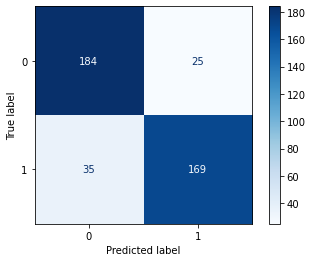

In [123]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_rf_cvec_gridsearch, X_test, y_test, df_results)

In [124]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


### Observations: 

The random forest model using a CountVectorizer achieved an accuracy of 86% as well as sensivity and specificity of 83.33% and 88.5% respectively.

In [125]:
pipe_rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=all_stopwords)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [126]:
pipe_rf_tvec_params = {
    'rf__n_estimators': [500], #[500, 1000],
    'rf__min_samples_split': [3], #[2, 3, 4] , # min. no of sample required to split, def:2
    'rf__min_samples_leaf': [1], #[1, 3, 5], # min. no. of samples required a leaf node, def:1
    'tvec__ngram_range': [(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [127]:
%%time
pipe_rf_tvec_gridsearch = GridSearchCV(
        pipe_rf_tvec, # What is the model we want to fit?
        pipe_rf_tvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 21.9 µs


In [128]:
%%time
# takes 20min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_rf_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 6.93 s, sys: 608 ms, total: 7.53 s
Wall time: 6.96 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [129]:
pipe_rf_tvec_gridsearch.best_score_

0.8489195910472507

In [130]:
# pipe_rf_tvec_gridsearch.best_params_

In [131]:
# pipe_rf_tvec_gridsearch.best_estimator_

Accuracy is 0.862.
Misclassification is 0.138.
Sensitivity is 0.8333.
Specificity is 0.89.
F1_score is 0.8564.


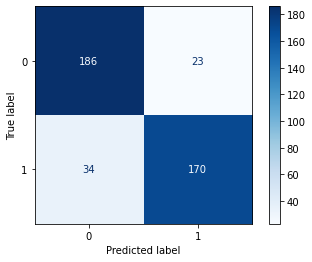

In [132]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_rf_tvec_gridsearch, X_test, y_test, df_results)

In [133]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


### Observations: 

The random forest model using a TfidfVectorizer achieved an accuracy of 87.4% as well as sensivity and specificity of 83.8% and 90.9% respectively.

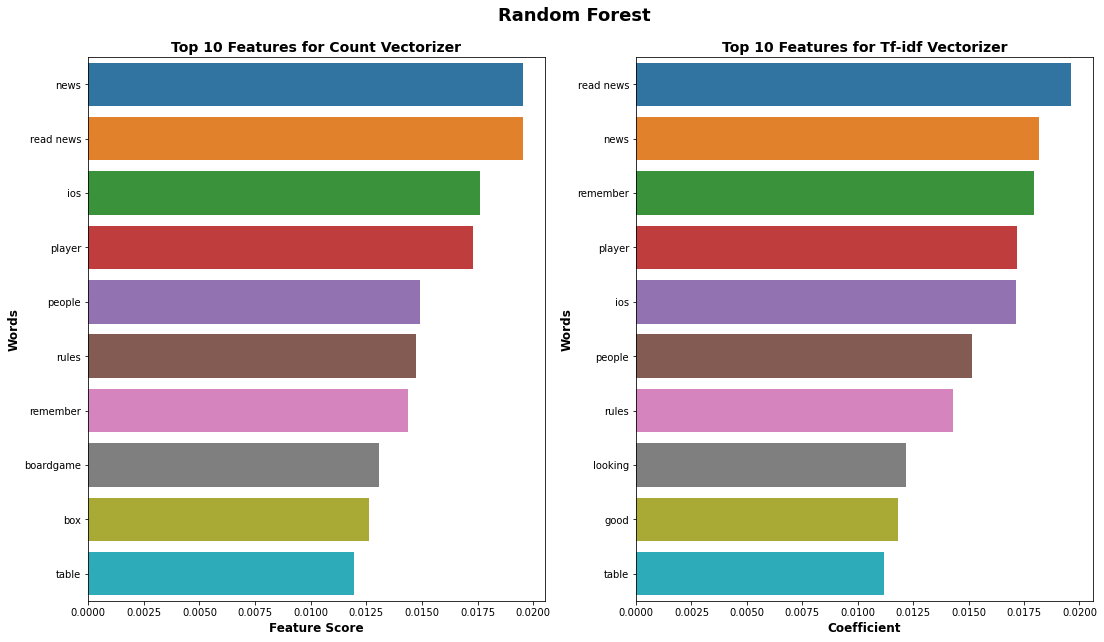

In [134]:
plot_top_features_tree([pipe_rf_cvec_gridsearch, pipe_rf_tvec_gridsearch], ['cvec', 'tvec'], 'rf', 10)

### Observations: 

From the 2 barcharts above, it can be observed that the top 10 features that are important in correctly classifying the 2 subrreddit groups. The higher the score of the features, the more important these features are to correctly classify the 2 groups. Likewise, one limitation is that we do not know which features/words are associated with which subreddit group, so the performance for sensitivity and specificity which associated with the false negative and false positive respectively cannot be explored further.

In [135]:
pipe_et_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=all_stopwords)),
    # split randomly unlike dt split by gini impurity
    ('et', ExtraTreesClassifier(random_state=42, n_jobs=-1)) 
])  

In [136]:
pipe_et_cvec_params = {
    'et__n_estimators': [1500], #[500, 1000, 1500],
    'cvec__ngram_range': [(1, 2)], #[(1, 2), (1, 3)],
    'cvec__max_df': [0.90], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'cvec__min_df': [0.01] #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [137]:
%%time
pipe_et_cvec_gridsearch = GridSearchCV(
        pipe_et_cvec, # What is the model we want to fit?
        pipe_et_cvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 16.9 µs


In [138]:
%%time
# takes about 12min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_et_cvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 12.7 s, sys: 1.41 s, total: 14.1 s
Wall time: 9.45 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [139]:
pipe_et_cvec_gridsearch.best_score_

0.86650824352952

In [140]:
# pipe_et_cvec_gridsearch.best_params_

In [141]:
# pipe_et_cvec_gridsearch.best_estimator_

Accuracy is 0.8305.
Misclassification is 0.1695.
Sensitivity is 0.848.
Specificity is 0.8134.
F1_score is 0.8317.


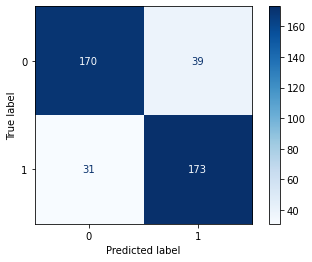

In [142]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_et_cvec_gridsearch, X_test, y_test, df_results)

In [143]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


### Observations: 

The random forest model using a CountVectorizer achieved an accuracy of 85% as well as sensivity and specificity of 85.29% and 84.7% respectively.

In [144]:
pipe_et_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=all_stopwords)),
    # splitExtraTreesClassifieromly unlike dt split by gini impurity
    ('et', ExtraTreesClassifier(random_state=42, n_jobs=-1)) 
])

In [145]:
pipe_et_tvec_params = {
    'et__n_estimators': [1500], #[500, 1000, 1500],
    'tvec__ngram_range': [(1, 3)], #[(1, 2), (1, 3)],
    'tvec__max_df': [0.9], #[0.9, 0.95, 0.98], # ignore words occur > specified value/% 
    'tvec__min_df': [0.01], #[0.01, 0.03, 0.05] # get words that occur > specified value/%
}

In [146]:
%%time
pipe_et_tvec_gridsearch = GridSearchCV(
        pipe_et_tvec, # What is the model we want to fit?
        pipe_et_tvec_params, # What is the dictionary of hyperparameters?
        cv=5, # What number of folds in CV will we use?
        verbose=1 # verbose=1 means print out everything
) 

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.1 µs


In [147]:
%%time
# takes about 5min
# takes about 2 min
# Fit the GridSearchCV object to the data
# if there is no key/value associated with knn, error
# need to pass in the scaled train data
pipe_et_tvec_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 13.2 s, sys: 1.38 s, total: 14.6 s
Wall time: 10 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['games',
                                                                    'game',
                                                                    'mobile',
                                                                    'board',
                                                                    'android',
                                                                    'like',
                                                                    'phone',
                                                                    'card',
                                                                    'cards',
                                                                    'whom',
                                                                    'moreover',
                                                                    'whenever',
    

In [148]:
pipe_et_tvec_gridsearch.best_score_

0.8750023026618772

In [149]:
# pipe_et_tvec_gridsearch.best_params_

In [150]:
# pipe_et_tvec_gridsearch.best_estimator_

Accuracy is 0.8717.
Misclassification is 0.1283.
Sensitivity is 0.8578.
Specificity is 0.8852.
F1_score is 0.8685.


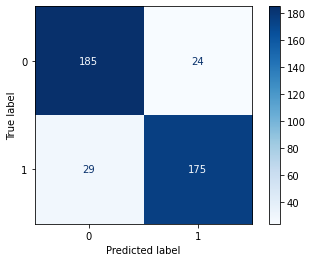

In [151]:
# df_results is used to save all the model metrics
# initially, pass in empty dataframe, subsequently, pass in existing dataframe to concatenate the results
df_results = compute_metrics(pipe_et_tvec_gridsearch, X_test, y_test, df_results)

In [152]:
df_results

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


### Observations: 

The random forest model using a TdidfVectorizer achieved an accuracy of 88.14% as well as sensivity and specificity of 85.78% and 90.43% respectively.

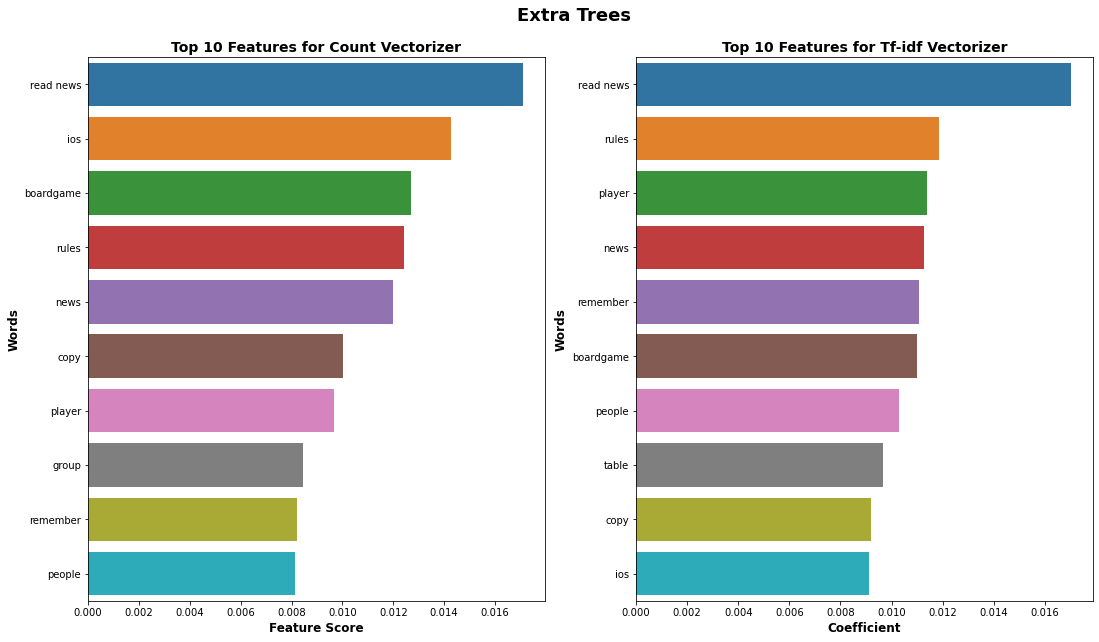

In [153]:
plot_top_features_tree([pipe_et_cvec_gridsearch, pipe_et_tvec_gridsearch], ['cvec', 'tvec'], 'et', 10)

### Observations: 

From the 2 barcharts above, it can be observed that the top 10 features that are important in correctly classifying the 2 subrreddit groups. The higher the score of the features, the more important these features are to correctly classify the 2 groups. However, one limitation is that we do not know which features/words are associated with which subreddit group.

## Misclassification Analysis

### Analysis is done for Naive Bayes and Logistic Regression as relative log probabilty of Naive Bayes and coefficient of Logistic regression can determine which features will affect how the posts can be classified

In [154]:
def check_fp_fn(df, row_list, gs_model_list, fp_test):
    fp_count = 0
    fn_count = 0
    count = 0
    
    if fp_test:
        test = 'fp_list'
    else:
        test = 'fn_list'
        
    for idx, gs_model in zip(row_list, gs_model_list):

        if (df_results['vectorizer'][idx] == 'cvec'):
#             print('in cvec')
            features = gs_model.best_estimator_['cvec'].get_feature_names()
                     
        elif (df_results['vectorizer'][idx] == 'tvec'):
#             print('tvec')
            features = gs_model.best_estimator_['tvec'].get_feature_names()
                  
                        
        if type(df_results['model'][idx]) == type(LogisticRegression()):
            
#             if test_fp:
            # associated with class 1
            coef_idx_desc = gs_model.best_estimator_['logreg'].coef_[0].argsort()[::-1]
            # associated with class 0
            coef_idx_asc = gs_model.best_estimator_['logreg'].coef_[0].argsort()
            feature_desc = [features[i] for i in coef_idx_desc]
            feature_asc = [features[i] for i in coef_idx_asc]
            

            for sentence in df_results[test][idx]:
                count += 1
                word_list = sentence.split()
                for word in word_list:
                    if word in feature_desc[:30]:
                        fp_count += 1
                    elif word in feature_asc[:30]:
                        fn_count += 1
                if fp_count > fn_count:
                    print(f'Classified "Boardgames" as there is more words occurence that are useful in classifying boardgames')#, fp_count, fn_count, count)
                elif fn_count > fp_count:
                    print('Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames')#, fn_count, fp_count, count)
                else:
                    print('Hard to classify as there is same number of words occurence that are useful in classifying boardgames and MobileGames')#, fn_count, fp_count, count)
            
        elif type(df_results['model'][idx]) == type(MultinomialNB()):

            #  get the probability diff 
            # higher means tend towards boardgame
            # associated with class 1
            log_prob_diff_bg = gs_model.best_estimator_['nb'].feature_log_prob_[1] \
                                - gs_model.best_estimator_['nb'].feature_log_prob_[0]
            # sort the index of coef in descending order
            log_prob_diff_bg_idx = log_prob_diff_bg.argsort()[::-1]
            # map index to feature list
            feature_bg = [features[i] for i in log_prob_diff_bg_idx]
#             # sort coef in desc order
#             feature_impt_bg = np.sort(log_prob_diff_bg)[::-1]
            
            #  get the probability diff 
            # higher means tend towards mobilegame
            # associated with class 0
            log_prob_diff_mg = gs_model.best_estimator_['nb'].feature_log_prob_[0] \
                                - gs_model.best_estimator_['nb'].feature_log_prob_[1]
            # sort the index of coef in descending order
            log_prob_diff_mg_idx = log_prob_diff_mg.argsort()[::-1]
            # map index to feature list
            feature_mg = [features[i] for i in log_prob_diff_mg_idx]
#             # sort coef in desc order
#             feature_impt_mg = np.sort(log_prob_diff_mg)[::-1]
            
            for sentence in df_results[test][idx]:
                count += 1
                word_list = sentence.split()
                for word in word_list:
                    if word in feature_bg[:30]:
                        fp_count += 1
                    elif word in feature_mg[:30]:
                        fn_count += 1
                if fp_count > fn_count:
                    print(f'Classified "Boardgames" as there is more words occurence that are useful in classifying boardgames')#, fp_count, fn_count, count)
                elif fn_count > fp_count:
                    print('Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames')#, fn_count, fp_count, count)
                else:
                    print('Hard to classify as there is same number of words occurence that are useful in classifying boardgames and MobileGames')#, fn_count, fp_count, count)


The function above try to analzye the false negative and false positive list on why these posts are classified wrongly. This function take the posts in the false positive list and try to check for if most of the words in a post appears in the top 30 words occurence that are useful in classifying boardgames and vice versa for mobile games.

The function is tested on the false negative list below and the results show that majority of the posts have more words occurence in classifying MobileGames, hence those posts are wrongly classified as MobileGames instead boardgames. This might due to the lack of key words that are available in the posts that cause the model to misclassify them. One possible way to reduce the misclassification can be by adding the common words that occur in the false negative or false positive post to the stopwords.

In [155]:
check_fp_fn(df_results, [2, 3], [pipe_nb_cvec_gridsearch, pipe_nb_tvec_gridsearch], False)

Hard to classify as there is same number of words occurence that are useful in classifying boardgames and MobileGames
Hard to classify as there is same number of words occurence that are useful in classifying boardgames and MobileGames
Hard to classify as there is same number of words occurence that are useful in classifying boardgames and MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words occurence that are useful in classifying MobileGames
Classified MobileGames" as there is more words

In [161]:
df_results#.sort_values(by='accuracy', ascending=False)

,model,vectorizer,accuracy,misclassification,sensitivity,specificity,precision,f1_score,tn,tp,fn,fp,fn_list,fp_list
0,LogisticRegression(),cvec,0.849879,0.150121,0.813725,0.885167,0.873684,0.842640,185,166,38,24,[i was recently reminded of the pop o matic i ...,[hello i recently got a ps also connected the ...
1,LogisticRegression(),tvec,0.857143,0.142857,0.852941,0.861244,0.857143,0.855037,180,174,30,29,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...
2,MultinomialNB(),cvec,0.857143,0.142857,0.897059,0.818182,0.828054,0.861176,171,183,21,38,[for example do you only need the app for were...,[recently i started playing mobile games again...
3,MultinomialNB(),tvec,0.840194,0.159806,0.882353,0.799043,0.810811,0.845070,167,180,24,42,[for example do you only need the app for were...,[recently i started playing mobile games again...
4,KNeighborsClassifier(),cvec,0.680387,0.319613,0.490196,0.866029,0.781250,0.602410,181,100,104,28,[it was hard to believe that there isn t any s...,[i don t know if this is the right place to as...
5,KNeighborsClassifier(),tvec,0.765133,0.234867,0.598039,0.928230,0.890511,0.715543,194,122,82,15,[our first game with players we get to the rai...,[recently i started playing mobile games again...
6,DecisionTreeClassifier(random_state=42),cvec,0.782082,0.217918,0.725490,0.837321,0.813187,0.766839,175,148,56,34,[i was recently reminded of the pop o matic i ...,[recently i started playing mobile games again...
7,DecisionTreeClassifier(random_state=42),tvec,0.731235,0.268765,0.745098,0.717703,0.720379,0.732530,150,152,52,59,[our first game with players we get to the rai...,[i don t know if this is the right place to as...
8,BaggingClassifier(base_estimator=DecisionTreeC...,cvec,0.799031,0.200969,0.779412,0.818182,0.807107,0.793017,171,159,45,38,"[pleasegimme ur best print n play games, for e...",[i don t know if this is the right place to as...
9,BaggingClassifier(base_estimator=DecisionTreeC...,tvec,0.825666,0.174334,0.769608,0.880383,0.862637,0.813472,184,157,47,25,[it was carribean ship trading and battle base...,[recently i started playing mobile games again...


In [160]:
# for sentence in df_results['fp_list'][0]:
#     print(sentence + '\n')

## Conclusion

| Model | Vectorizer | Misclassification | Accuracy | Sensitivity | Specificity | Precision | F1_score |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | cvec | 0.849 | 0.151 | 0.814 | 0.885 | 0.874 | 0.842 |
| Logistic Regression | tvec | 0.857 | 0.143 | 0.852 | 0.861 | 0.857 | 0.855 |
| MultinomialNB | cvec | 0.857 | 0.143 | 0.897 | 0.818 | 0.828 | 0.861 |
| MultinomialNB | tvec | 0.84 | 0.16 | 0.882 | 0.799 | 0.811 | 0.845 |
| KNeighborsClassifier | cvec | 0.68 | 0.32 | 0.49 | 0.866 | 0.781 | 0.602 |
| KNeighborsClassifier | tvec | 0.765 | 0.235 | 0.598 | 0.928 | 0.8901 | 0.716 |
| DecisionTreeClassifier | cvec | 0.782 | 0.217 | 0.725 | 0.837 | 0.813 | 0.767 |
| DecisionTreeClassifier | tvec | 0.731 | 0.269 | 0.745 | 0.7178 | 0.72 | 0.733 |
| BaggingClassifier | cvec | 0.799 | 0.201 | 0.779 | 0.818 | 0.807 | 0.793 |
| BaggingClassifier | tvec | 0.825 | 0.174 | 0.77 | 0.88 | 0.863 | 0.813 |
| RandomForestClassifier | cvec | 0.855 | 0.145 | 0.828 | 0.88 | 0.871 | 0.849 |
| RandomForestClassifier | tvec | 0.862 | 0.138 | 0.833 | 0.89 | 0.881 | 0.856 |
| ExtraTreesClassifier | cvec | 0.831 | 0.169 | 0.848 | 0.813 | 0.816 | 0.832 |
| ExtraTreesClassifier | tvec | 0.872 | 0.128 | 0.858 | 0.885 | 0.879 | 0.868 |

In this section, 14 models have been built for classification purpose. As our aim is to correctly classify the 2 groups, hence specificity and sensitivty are also important metrics in addition to accuracy. As the Extra Tree classifier with TfidfVectorizer achieve the highest accuracy of 87.1% as well as sensitivity and specificity of 85.8% and 88.5% respectively, this model will be chosen for the model to be used to classify between MobileGaming and Boardgames.